# Влияние комиссии агрегатора на рынок такси в Москве

19.01.2021, Жук С.Н. (РАНХиГС, zhuk-sn@ranepa.ru)

## 1. Модель

* Для вычислений использовалась модель из 
    * Castillo, Juan Camilo, Dan Knoepfle, and Glen Weyl. “Surge Pricing Solves the Wild Goose Chase.” In Proceedings of the 2017 ACM Conference on Economics and Computation, 241–42, 2017.


* Агрегатор такси обрабатывает заказы клиентов и для каждого клиента находит ближайшего свободного водителя.
    * Агрегатор устанавливает цену на поездку $P$, которую платит клиент.
    * Агрегатор устанавливает размер комиссии $f$: водитель получает $(1-f)\cdot P$ за поездку.


* Спрос на услуги такси 
    * Количество клиентов на определенной территории в единицу времени $N_C$ определяется определяется средней ценой за поездку $P$ (которую устанавливает агрегатор) и средним временем ожидания $T$:
    $$N_C = d(P,T)$$


* Количество работающих водителей
    * Количество  работающих водителей $N_D$ определяется их средним заработком $W$: $N_D = s(W)$.
    * Средний заработок можно вычислить как $W = \frac{P\cdot N_C\cdot(1-f)}{N_D}$ (для простоты предполагается, что водитель ездит все рабочее время, но можно ли легко обобщить модель и на случай, когда издержки от ожидания меньше издержек от поездки).



* Время ожидания
    * Предположим, что среднее время поездки равно $t$, тогда среднее количество свободных водителей $I$ равно:
$$I = N_D - N_C\cdot (T+t)$$
    * Мы предполагаем, что среднее время ожидания $T$ - это некоторая убывающая функция от среднего количества свободных водителей $T(I)$.
        * Эта функция определяется географией города. Например, для двухмерного города, с равномерным распределением заказов и где водитель может ехать напрямую к клиенту $T(I) \sim 1/\sqrt{I}$.
    * Для расчетов обычно удобнее использовать обратную функцию $I(T)$. В этом случае получаем следующее уравнение, определяющее время ожидания $T$ для заданного кол-ва водителей $N_D$ и кол-ва заказов в единицу времени $N_C$:
$$N_D = N_C\cdot(T+t) + I(T)$$








Код ниже для заданных функций $d(P, T)$, $s(W)$ и $I(T)$ и выбранного уровня комиссии агрегатора $f$ вычисляет, какое установится равновесие на рынке:
* *solveT(M, P, T)*: вычисляет спрос $N_C$ и необходимое предложение $N_D$ для заданного уровня цены $P$ и времени ожидание $T$ (реальное предложение $N_D$ при этом может отличаться от необходимого).
* *solve(M, P)*: вычисляет время ожидания $T$, при котором предложение водителей $N_D$ на рынке находится в равновесии при заданном уровне цен $P$.
* *solve(M)*: вычисляет оптимальный уровень цен $P$, который установит платформа.

Для примеров использования, смотрите раздел ниже про калибровку модели.

In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
class model: 
    def __str__(self):
        return self.__dict__.__str__()

In [2]:
def solveT(M, P, T):
    res = model()
    res.NC = M.D(P, T)
    res.ND = res.NC*(T + M.t)/M.tau + M.I(T)
    res.pi = res.NC*P
    res.W = res.NC/res.ND*(P*(1-M.f) - M.gamma*(T+M.t))  
    res.I = M.I(T)
    return res

def solveP(M, P):
    def f(T):
        r = solveT(M, P, T)
        return r.ND - M.S(r.W)
    def findT():
        T = M.Tmin; dt = M.dT; f0 = f(T)
        Tlist = []
        while T<M.Tmax:
            T = T + M.dT
            if M.D(P, T) <= 0: break
            if P*(1-M.f)-M.gamma*(T+M.t)<=0: break
            f1 = f(T)
            if f0*f1 <= 0: Tlist.append(optimize.root_scalar(f, bracket = [T-M.dT, T]).root)
            f0 = f1
        return Tlist
    Tlist = findT()
    if len(Tlist) > 0:
        res = solveT(M, P, Tlist[0])
        res.T = Tlist[0]
    else:
        res = solveT(M, P, M.Tmin)
        for k in res.__dict__:
            setattr(res, k, np.nan)
        res.T = np.nan
    #res.Tlist = Tlist
    return res

def solve(M):
    def g(P):
        r = solveP(M, P)
        if np.isnan(r.pi): return 0
        return -r.pi
    if hasattr(M, 'P'):
        P = M.P
    else:
        P = np.nan
        P0 = M.P0min 
        while (P0<=M.P0max):
            if g(P0)<0:
                P = optimize.minimize(g, x0=P0).x[0]
                break
            P0 += M.dP0 
    res = solveP(M, P)
    res.P = P
    res.PP = M.f*res.pi
    res.CS = CS(M, res.P, res.T)
    res.PS = PS(M, res.W)
    res.SW = res.PP + res.CS + res.PS
    return res

def CS(M, p, T):
    if np.isnan(p): return np.nan
    if hasattr(M, 'pmax'):
        pmax = M.pmax
    else:
        pmax = optimize.root_scalar(lambda x: M.D(x, T), x0 = M.P0, x1 = M.P0*1.05).root
    if (p>pmax): return 0
    return integrate.quad(lambda x: M.D(x, T), p, pmax)[0]
    
def PS(M, W):
    if np.isnan(W): return np.nan
    if hasattr(M, 'Wmin'):
        Wmin = M.Wmin
    else:
        Wmin = optimize.root_scalar(M.S, x0 = 100, x1 = 200).root
    if (W<Wmin): return 0
    return integrate.quad(M.S, Wmin, W)[0]

def vresults(M, d):
    Mt = copy.copy(M)
    res = model()
    keys = d.keys()
    n = len(d[list(keys)[0]])
    for i in range(0,n):
        for k in keys:
            setattr(Mt, k, d[k][i])
        r = solve(Mt)
        if i == 0:
            for k in r.__dict__.keys(): setattr(res, k, np.array([getattr(r, k)]))
        else:
            for k in r.__dict__.keys(): setattr(res, k, np.append(getattr(res, k), getattr(r, k)))
    return res

## 2. Калибровка модели для Москвы

Для вычислений успользовались функции с постоянными эластичностями:

$$
\begin{array}{l}
N_C = D(P,T) = A_C \cdot P^{-\varepsilon_P}\cdot T^{-\varepsilon_T} \\
N_D = S(W) = A_D \cdot W^{\varepsilon_W} \\
T(I) = A_T \cdot I^{-\varepsilon_I}
\end{array}
$$

В уравнениях выше $\varepsilon_P$, $\varepsilon_T$, $\varepsilon_T$ и $\varepsilon_I$ - это неизвестные эластичности, показывающие на сколько процентов изменится спрос, предложение или время ожидания при изменении соответствующего параметра на 1%. Параметры $A_C$, $A_D$ и $A_W$ - это также дополнительные неизвестные константы. Также как и Castillo et al (2017) мы предполагаем, что цена $P$ и время ожидания $T$ - это две независимые мультипликативные компоненты влияющие на спрос.

Для калибровки модели использовались следующие данные: 
* Количество поездок в день в Москве в 2020 году  - 909 тысяч, доля Яндекс.Такси - 70%, среднее время ожидания - 4 мин, средняя стоимость поездки - 457 руб.
    * Источник: Дептранс Москвы
    * https://t.me/DtRoad/5210
    * https://t.me/DtRoad/5409
    * https://tass.ru/ekonomika/10465451
* Средний зароботок водителей Яндекс такси - 500 рублей в час до вычета комиссии. 
    * Источник: отзывы водителей в интернете.
    * Например: *Работаю в Москве,в тарифе Эконом, выхожу с 8ч до 22ч,как ни крути,в час грязными выходит 500р. Итого : 14×500 = 7000р (+/-),бывает и 8ку накатываю. Из них вычитаем 1500 (% Яшки),1500 (аренда),1000 (бенз),при накате 8ки, соответственно чуть больше. Итого чистыми выходит в районе 3000 в день. Минус свои траты : попить,поесть.*
* Средняя комиссия агрегатора - 20%
    * Источник: отзывы водителей и также https://pro.yandex/ru-ru/moskva/base/comission
* Среденее время поездки - 25 минут.
    * Источник: https://yandex.ru/company/researches/2015/moscow/taxi
* Площадь Москвы (без Новой Москвы) - 1070 км2.
    
Данные выше позволяют вычислить константы вычислить:
* равновесное количество клиентов в единицу времени $N_C$,
* среднее кол-во одновременно работающих водителей $N_D$ и среднее количество свободных водителей $I$,
* а также константы $A_C$, $A_D$ и $A_T$.

Кроме того мы знаем среднюю цену поездки $P$ и средний чистый заработок водителей $W$, среднее время поездки $t$ и среднее время ожидания $T$.

Для определения эластичностей можно использовать следующие соображения:
1. Текущая цена должна быть оптимальной для агрегатора
    * Из условия оптимальности цены (см. приложение ниже) получается слудующее уравнение, связывающее эластичности $\varepsilon_P$, $\varepsilon_T$ и $\varepsilon_I$:
    $$\varepsilon_P = 1 + \varepsilon_T\cdot\frac{T+t}{\frac{I/N_C}{\varepsilon_I}-T}$$
2. Текущий уровень комиссии должен быть оптимальным для агрегатора
    * Из условия оптимальности комиссии (см. приложение ниже) получается дополнительно следующее уравнение, связывающее эластичности $\varepsilon_P$, $\varepsilon_W$:
$$
1 + \frac{1}{\varepsilon_W} 
=\frac{P}{W\cdot(T+t)}\cdot\left(1 - \frac{1}{\varepsilon_P}\right)
$$
    * (ниже для более консервативной оценки мы ослабим это предположение: так как сейчас на рынке есть некоторый уровень конкуренции, то, возможно, комиссия пока чуть той, что максимизируют прибыль платформы).

Два уравения оптимальности позволяют нам вычислить две эластичности, и соответственно оставшиеся две придется задать в ручную. Код приведенный ниже (функция calibratedModel задает откалиброванную модель для каких-либо двух выбранных эластичностей.

Вместо самих эластичностей можно также задать следующие параметры, однозначно определяющие эластичности $\varepsilon_P$ и $\varepsilon_T$ (эти параметры имеют более понятную и осязаемую интерпретацию, поэтому в основном использовались именно они):
* $\eta_T = \varepsilon_T/T$: полу-эластичность, показывающая на сколько процентов должен уменьшится спрос при увеличении времени ожидания на 1 минуту.
* $b = \frac{\varepsilon_T/T}{\varepsilon_P/P}$: показывает сколько рублей клиенты готовы заплатить за то, чтобы уменьшить время ожидания на одну минуту.



In [3]:
def calibratedModel(**pm):
    # 1. Data
    M = model()
    M.f = 0.2
    M.t = 25
    M.tau = 60 # Number of clients is calculated per hour and time is in minutes
               # tau is the length of the considered interval for the number of clients in minutes
    T = 4
    P = 457
    f = 0.2
    W = 500*(1-M.f) 
    NC = 910000*0.7/16/1070
    ND = NC*P*(1-M.f)/W
    I = ND - NC*((M.t+T)/60)    
    
    # 2. Calculating remaining elasticities from the ones that are given
    if 'etaT' in pm: pm['epsT'] = pm['etaT']*T
    if ('b' in pm) and ('epsT' in pm): pm['epsP'] = P*(pm['epsT']/T)/pm['b']
    if ('b' in pm) and ('epsP' in pm): pm['epsT'] = T*(pm['epsP']/P)*pm['b']
        
    if ('b' not in pm): pm['b'] = (pm['epsT']/T)/(pm['epsP']/P)
    if ('etaT' not in pm): pm['etaT'] = pm['epsT']/T
    if ('epsI' not in pm):
        eTNC = (pm['epsP'] - 1)/pm['epsT']
        dTNC = eTNC*T/NC
        pm['epsI'] = (M.tau/T)*I/(NC+(T+M.t)/dTNC)
    if ('epsW' not in pm):
        ratio = (P/(T+M.t))/(W/M.tau)
        pm['epsW'] = 1/((1-1/pm['epsP'])*ratio-1)
    for it in ['epsP', 'epsT', 'epsI', 'epsW']: setattr(M, it, pm[it])
    if ('quiet' not in pm):
        print('b = dP/dT = ', pm['b'])
        print('etaT = ', pm['etaT'])
        print('epsT = ', pm['epsT'])
        print('epsP = ', pm['epsP'])        
        print('epsW = ', pm['epsW'])
        print('epsI = ', pm['epsI'])
    
    # 3. Parameters of the numerical solution
    M.Tmin = 1
    M.Tmax = 90
    M.dT = 1
    M.P0min = 350
    M.P0max = 550
    M.dP0 = 20
    M.pmax = np.inf
    M.Wmin = 100
    
    # 4. Geography
    A_T = T*(I**M.epsI)
    M.I = lambda T: (A_T/T)**(1/M.epsI)

    #Supply
    M.gamma = 0
    A_D = 1
    M.S = lambda W: A_D*((W/1000)**M.epsW)
    A_D = ND/M.S((1-M.f)*NC*P/ND)

    #Demand
    A_C = 1
    M.D = lambda P, T: A_C*((P/1000)**(-M.epsP))*((T/10)**(-M.epsT))
    A_C = NC/M.D(P, T)
    return M
    
M = calibratedModel(b = 10, etaT = 0.05)
print('\nCalbirated model:', M)
print('\nResulting equilibrium:', solve(M))

b = dP/dT =  10
etaT =  0.05
epsT =  0.2
epsP =  2.285
epsW =  3.0366492146596853
epsI =  3.035137111517368

Calbirated model: {'f': 0.2, 't': 25, 'tau': 60, 'epsP': 2.285, 'epsT': 0.2, 'epsI': 3.035137111517368, 'epsW': 3.0366492146596853, 'Tmin': 1, 'Tmax': 90, 'dT': 1, 'P0min': 350, 'P0max': 550, 'dP0': 20, 'pmax': inf, 'Wmin': 100, 'I': <function calibratedModel.<locals>.<lambda> at 0x11f62b1f0>, 'gamma': 0, 'S': <function calibratedModel.<locals>.<lambda> at 0x11f62b280>, 'D': <function calibratedModel.<locals>.<lambda> at 0x11f62b310>}

Resulting equilibrium: {'NC': 37.20794183977933, 'ND': 34.008060747662334, 'pi': 17004.03037383094, 'W': 399.99999999999477, 'I': 16.024223085037015, 'T': 3.999998559552647, 'P': 457.0000256142033, 'PP': 3400.8060747661884, 'CS': 13232.70846215319, 'PS': 3357.4180684301637, 'SW': 19990.932605349542}


## 3. Результаты: влияние комиссии на рынок

### Уменьшение комиссии с 20% до 10%

In [4]:
def feeChange(M, ffrom, fto):
    M.f = ffrom; rfrom = solve(M)
    M.f = fto; rto = solve(M)
    res = dict()
    for v in ['P', 'W', 'T', 'NC', 'ND', 'I']:
        vfrom = np.round(getattr(rfrom, v), 2); vto = np.round(getattr(rto, v), 2);
        pct = np.round(100*(vto-vfrom)/vfrom, 2)
        res[v] = [vfrom, vto, pct]
    res = pd.DataFrame(res, index = ['comission = {}%'.format(ffrom*100), 
                                     'comission = {}%'.format(fto*100)
                                     , 'change in % ({}%->{}%)'.format(ffrom*100,fto*100)])
    display(res)
    print('Change in platform profits: {:.2f}'.format(rto.PP-rfrom.PP))
    print('Change in social welfare: {:.2f} ({:.2f}% of platform losses)'.format(rto.SW-rfrom.SW, 
            100*(rto.SW-rfrom.SW)/(rfrom.PP-rto.PP)))
    print('Change in consumer surplus: {:.2f} ({:.2f}% of platform losses)'.format(rto.CS-rfrom.CS, 
            100*(rto.CS-rfrom.CS)/(rfrom.PP-rto.PP)))
    print('Change in driver surplus: {:.2f} ({:.2f}% of platform losses)'.format(rto.PS-rfrom.PS, 
            100*(rto.PS-rfrom.PS)/(rfrom.PP-rto.PP)))
    
M = calibratedModel(b = 10, etaT = 0.05)
feeChange(M, 0.2, 0.1)

b = dP/dT =  10
etaT =  0.05
epsT =  0.2
epsP =  2.285
epsW =  3.0366492146596853
epsI =  3.035137111517368


,P,W,T,NC,ND,I
comission = 20.0%,457.00,400.00,4.00,37.21,34.01,16.02
comission = 10.0%,382.92,450.81,2.01,63.97,48.90,20.10
change in % (20.0%->10.0%),-16.21,12.70,-49.75,71.92,43.78,25.47


Change in platform profits: -951.46
Change in social welfare: 6967.93 (732.34% of platform losses)
Change in consumer surplus: 5828.33 (612.57% of platform losses)
Change in driver surplus: 2091.06 (219.77% of platform losses)


### Графики: влияние размера комиссии на рынок

b = dP/dT =  10
etaT =  0.05
epsT =  0.2
epsP =  2.285
epsW =  3.0366492146596853
epsI =  3.035137111517368


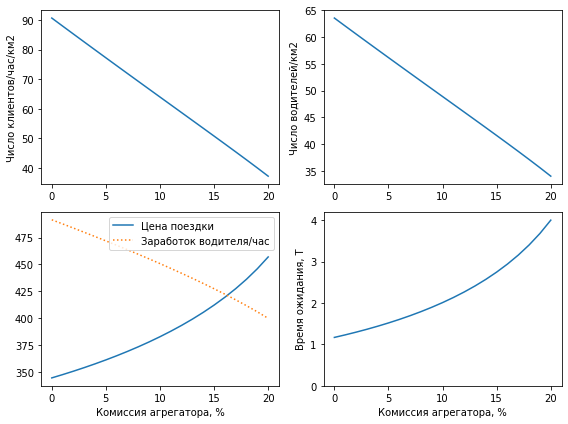

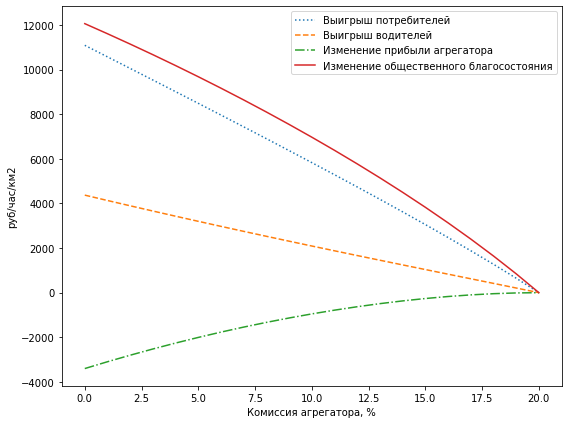

In [5]:
M = calibratedModel(b = 10, etaT = 0.05)
f = np.arange(0.0, 0.21, 0.01)
res = vresults(M, {'f': f})

def plotResults(f, res):
    plt.figure(figsize = (8,6))
    plt.subplot(221)
    plt.plot(100*f, res.NC); #plt.ylim(ymin=0, ymax = max(res.NC)*1.05)
    plt.ylabel('Число клиентов/час/км2')

    plt.subplot(222)
    plt.plot(100*f, res.ND); #plt.ylim(ymin=0, ymax = max(res.ND)*1.05)
    plt.ylabel('Число водителей/км2')

    plt.subplot(223)
    plt.plot(100*f, res.P, '-')
    plt.plot(100*f, res.W, ':')
    plt.legend(['Цена поездки', 'Заработок водителя/час'])
    plt.xlabel('Комиссия агрегатора, %')
    plt.subplot(224)
    plt.plot(100*f, res.T); plt.ylim(ymin = 0, ymax = max(res.T)*1.05)
    plt.ylabel('Время ожидания, T')
    plt.xlabel('Комиссия агрегатора, %')
    plt.tight_layout()

    plt.figure(figsize = (8,6))
    for fi in range(0, len(f)):
        if f[fi]>=0.2: break
    plt.plot(100*f, res.CS-res.CS[fi], ':')
    plt.plot(100*f, res.PS-res.PS[fi], '--') 
    plt.plot(100*f, res.PP-res.PP[fi], '-.') 
    plt.plot(100*f, res.SW-res.SW[fi], '-')
    plt.legend(['Выигрыш потребителей','Выигрыш водителей', 
                'Изменение прибыли агрегатора', 'Изменение общественного благосостояния'])
    plt.xlabel('Комиссия агрегатора, %'); plt.ylabel('руб/час/км2')
    plt.tight_layout()

plotResults(f, res)

## 4. Консервативная оценка

В данном разделе мы предполагаем, что некоторый уровень конкуренции на рынке присутствует. В частности, мы будем считать, что уровень, комиссии максимизирующий прибыль агрегаторов выше текущего (в расчетах ниже мы использовали 30%). Это позволяет получить чуть более консервативные оценки влияния ограничения комиссии на рынок (выигрыш обчественного благосостояния получается чуть меньше, а потери платформы чуть больше).

Для расчетов мы теперь не используем уравнение, определящее эластичность $\varepsilon_W$, а подбираем значение этого параметра так, чтобы прибыль агегатора была максимальной для выбранного уровня в 30%. Функция *conserativeModel(...)* осуществляет этот подбор и создает соответствующую модель.

In [6]:
def conservativeModel(**pm):
    df = 0.01
    epsW0 = pm['epsW'] if 'epsW' in pm else 1
    def diff(eW):
        pm['epsW'] = eW 
        M = calibratedModel(**pm, quiet = True)
        M.P0min = 350
        M.P0max = 550
        M.f = pm['ftarget']+df; rp = solve(M)
        M.f = pm['ftarget']-df; rm = solve(M)
        return rp.PP-rm.PP
    pm['epsW'] = optimize.root_scalar(diff, x0 = epsW0, x1 = epsW0*0.95).root
    return calibratedModel(**pm)
    
M = conservativeModel(b = 10, etaT = 0.05, ftarget = 0.3)
feeChange(M, 0.2, 0.1)

b = dP/dT =  10
etaT =  0.05
epsT =  0.2
epsP =  2.285
epsW =  1.495923452309848
epsI =  3.035137111517368


,P,W,T,NC,ND,I
comission = 20.0%,457.00,400.00,4.00,37.21,34.01,16.02
comission = 10.0%,415.65,452.62,2.84,49.50,40.91,17.95
change in % (20.0%->10.0%),-9.05,13.16,-29.00,33.03,20.29,12.05


Change in platform profits: -1343.13
Change in social welfare: 3406.72 (253.64% of platform losses)
Change in consumer surplus: 2780.31 (207.00% of platform losses)
Change in driver surplus: 1969.54 (146.64% of platform losses)


b = dP/dT =  10
etaT =  0.05
epsT =  0.2
epsP =  2.285
epsW =  1.495923452309848
epsI =  3.035137111517368


,P,W,T,NC,ND,I
comission = 20.0%,457.00,400.00,4.00,37.21,34.01,16.02
comission = 10.0%,415.65,452.62,2.84,49.50,40.91,17.95
change in % (20.0%->10.0%),-9.05,13.16,-29.00,33.03,20.29,12.05


Change in platform profits: -1343.13
Change in social welfare: 3406.72 (253.64% of platform losses)
Change in consumer surplus: 2780.31 (207.00% of platform losses)
Change in driver surplus: 1969.54 (146.64% of platform losses)


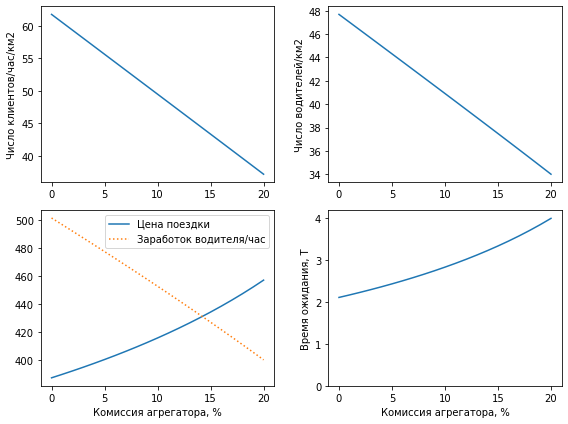

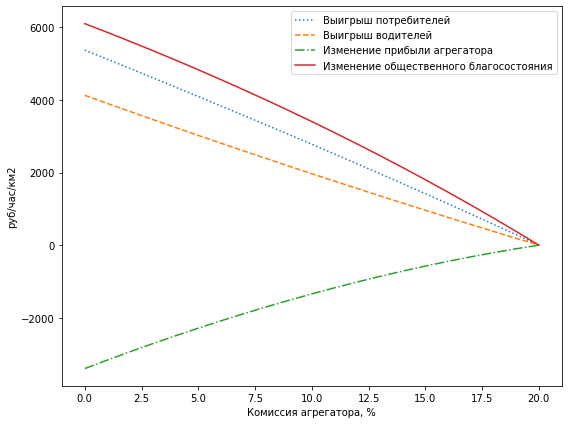

In [7]:
M = conservativeModel(b = 10, etaT = 0.05, ftarget = 0.3)
feeChange(M, 0.2, 0.1)
f = np.arange(0, 0.21, 0.01)
res = vresults(M, {'f': f})
plotResults(f, res)

## 5. Приложение

### 5.1 Задача максимизации прибыли для агрегатора

Задача маскимизации прибыли агрегатора в общем случае (у агрегатора также могут быть фиксированные издержки на поддержание работоспособности платформы, но так как они фиксированные и не влияют выбор параметров их можно опустить):

$$
\begin{array}{ll}
& f\cdot N_C\cdot P \rightarrow \max_{P, f} \\ \\
s.t. &N_C = D(P,T) \\
&N_D = S\left(\frac{P\cdot N_C\cdot(1-f)}{N_D}\right) \\
&N_D = N_C\cdot(T+t) + I(T)
\end{array}
$$

Задача маскимизации агрегатора для выбранных функций спроса и предложения:

$$
\begin{array}{ll}
& f\cdot N_C\cdot P \rightarrow \max_{P, f} \\ \\
s.t. &N_C = A_C \cdot P^{-\varepsilon_P}\cdot T^{-\varepsilon_T} \\
&N_D = A_D \cdot{\left(\frac{P\cdot N_C\cdot(1-f)}{N_D}\right)}^{-\varepsilon_W} \\
&N_D = N_C\cdot(T+t) + {\left(\frac{T}{A_T}\right)}^{-1/\varepsilon_I}
\end{array}
$$

Условия оптимальности ниже выведены для данных задач максимизации.

### 5.2 Оптимальный уровень цен

Сначала зафиксируем уровень комиссии $f$ и рассмотрим задачу выбора оптимальной цены $P$. 
1. Оказывается удобнее рассмотреть обратную функцию спроса $P(N_C, T)$ (показывающую какую цену агрегатор должен установить для того, чтобы спрос был равен $N_C$ при времени ожидания $T$) и заменить выбор оптимального уровня $P$ на выбор оптимального количества клиентов $N_C$. 
2. Также рассмотрим $T(N_C,N_D)$ как неявную функцию, определяемую уравнением: $N_D = N_C\cdot(T+t) + I(T)$.
3. И наконец, заметим, что при постоянной комиссии, цена максимизирующая прибыль платформы также максимизирует суммарный заработок водителей (а значит и количество работающих водителей). Поэтому $\frac{dN_D}{dN_C}=0$ в точке оптимума.

Теперь мы можем записать следующее условие первого порядка для $N_C$:

$$1 + \frac{\partial\log P}{\partial\log N_C} + \frac{\partial\log P}{\partial\log T}\cdot \frac{\partial\log T}{\partial\log N_C} = 0$$

Для выбранных функций спроса и предложения:

$$
\begin{array}{l}
\frac{\partial\log P}{\partial\log N_C} = -\frac{1}{\varepsilon_P} \\
\frac{\partial\log P}{\partial\log T} 
= -\frac{\frac{\partial\log N_C}{\partial\log T}}{\frac{\partial\log N_C}{\partial\log P}}
= -\frac{\varepsilon_T}{\varepsilon_P}
\end{array}
$$

Кроме того (из уравнения $N_D = N_C\cdot(T+t) + I(T)$):

$$\frac{\partial\log T}{\partial\log N_C}
=\frac{N_C}{T}\cdot\frac{\partial T}{\partial N_C}
=-\frac{N_C}{T}\cdot\frac{T+t}{N_C+\frac{dI}{dT}}
=\frac{N_C}{T}\cdot\frac{T+t}{\frac{I}{T}\frac{1}{\varepsilon_I}-N_C}$$

В итоге получаем следующее уравнение связывающие эластичности $\varepsilon_P$, $\varepsilon_T$ и $\varepsilon_I$:

$$\varepsilon_P 
= 1 + \varepsilon_T\cdot\frac{\partial\log T}{\partial\log N_C}
= 1 + \varepsilon_T\cdot\frac{T+t}{\frac{I/N_C}{\varepsilon_I}-T}$$

Заметим, что это уравнение должно выполняться, даже если текущий уровень комиссии не является оптимальным для агрегатора.

### 5.3 Оптимальный уровень комиссии

Рассмотрим теперь одновременный оптимальный выбор $P$ и $f$. 
1. Опять будем использовать обратную функцию спроса $P(N_C, T)$ и соответсвественно предполагаем, что агрегатор вместо цены оптимизирует спрос $N_C$.
2. Предположим, что вместо комиссии агрегатор выбирает, какой будет средний заработок водителей $W = \frac{P\cdot N_C\cdot(1-f)}{N_D}$. Тогда прибыль агрегатора можно записать как $ f\cdot P\cdot N_C = P\cdot N_C - s(W)\cdot W$
3. И наконец, вместо функции предложения $s(W)$ можно исользовать обратную функцию $W(N_D)$, показывающую какую зарплату нужно платить водителям, чтобы предложение было равно $N_D$.

Задача максимизации для агрегатора в итоге превращается в

$$
\begin{array}{l}
 N_C\cdot P(N_C, T) - N_D\cdot W(N_D)\rightarrow \max_{N_C, N_D} \\
s.t.\  N_D = N_C\cdot(T+t) + I(T)
\end{array}
$$

Условия первого порядка для $N_C$ и $N_D$:
$$
\begin{array}{l}
1 + \frac{\partial\log P}{\partial\log N_C} + \frac{\partial\log P}{\partial\log T}\cdot \frac{\partial\log T}{\partial\log N_C} = 0 \\
N_C\cdot\frac{\partial P}{\partial T}\cdot\frac{\partial T}{\partial N_D} 
 - W(N_D)- N_D\cdot\frac{dW(N_D)}{dN_D} = 0
\end{array}
$$

Второе уравнение можно переписать как:

$$
N_C\cdot\frac{\partial P}{\partial T}\cdot\frac{\partial T}{\partial N_D} 
= W\cdot\left(1 + \frac{d\log W}{d\log N_D}\right)
$$
Кроме того
$$
\frac{\partial\log P}{\partial\log T}\cdot \frac{\partial\log T}{\partial\log N_C}=
\frac{N_C}{P}\cdot\frac{\partial P}{\partial T}\cdot\frac{\partial T}{\partial N_C}
\qquad\qquad
\frac{\frac{\partial T}{\partial N_C}}{\frac{\partial T}{\partial N_D}} 
= -\frac{\partial N_D}{\partial N_C} = -(T+t) 
$$

Поэтому из уравнений первого порядка получается следующее уравнение связывающее непосрественно спрос и предложение:

$$
1 + \frac{d\log W}{d\log N_D}
=\frac{P}{W\cdot(T+t)}\cdot\left(1 + \frac{\partial\log P}{\partial\log N_C}\right)
$$

или используя эластичности его можно переписать, как: 

$$
1 + \frac{1}{\varepsilon_W} 
=\frac{P}{W\cdot(T+t)}\cdot\left(1 - \frac{1}{\varepsilon_P}\right)
$$

### 5.4 Анализ соотношения между $\varepsilon_P$ и $\varepsilon_W$

Уравнение оптмальности комиссии
$$
1 + \frac{1}{\varepsilon_W} 
=\frac{P}{W\cdot(T+t)}\cdot\left(1 - \frac{1}{\varepsilon_P}\right)
$$
характреризует возможные значения эластичностей спроса $\varepsilon_P$ и предложения $\varepsilon_W$. График ниже показывает, какие сочетания значений возможны.

epsP min = 1.7332490518331225
epsW min = 0.7332490518331226


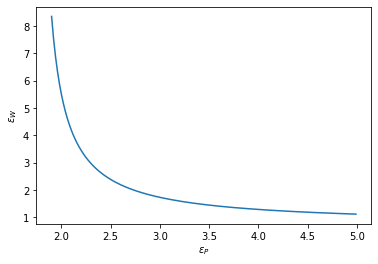

In [8]:
T = 4; t = 25; tau = 60
P = 457; W = 500*0.8
ratio = (P/(T+t))/(W/tau)
print('epsP min =', ratio/(ratio-1))
print('epsW min =', 1/(ratio-1))

eP = np.arange(1.9, 5, 0.01);
eW = 1/(ratio*(1-1/eP)-1)

plt.figure()
plt.plot(eP, eW); plt.xlabel('$\\varepsilon_P$'); plt.ylabel('$\\varepsilon_W$'); pass

Заметим, что существуют минимальные допустимые значения:
* $\varepsilon_P\ge 1.73$ 
* $\varepsilon_W\ge 0.73$ 

Отсюда в частности следуют, что нужно выбирать параметры $b$ и $\eta_T$ так чтобы:

$$\varepsilon_P = \frac{\eta_T}{b/P}\ge 1.73\qquad\Leftrightarrow\qquad
b\le \frac{P\cdot\eta_T}{1.73} = 263.67\cdot\eta_T
$$